In [1]:
import time
import sys

import numpy as np
import pandas as pd
from scipy.misc import derivative
import scipy.integrate as intg
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
# from tensorflow.keras.layers import Input, Dense
# from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam
# from tensorflow.keras.initializers import Constant, RandomNormal

from sklearn.metrics import mean_squared_error
from astroNN.nn.layers import MCDropout

sys.path.append("/home/isidro/Documents/github/nnogada/")
from nnogada import Nnogada

np.random.seed(0)

2023-08-27 20:48:09.416938: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-27 20:48:10.024731: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# tf.config.list_physical_devices('GPU')


In [3]:
data_folder = 'Data_SNIa_LSST/larger/'
df_data = pd.read_csv(data_folder+'hubble_diagram.txt', skiprows=5, sep=' ')
# Np = len(dfp.values)
# N s=  len(dfs.values)
df_data.head()

,CID,IDSURVEY,zCMB,zHEL,MU,MUERR,MUERR_VPEC,MUERR_SYS
0,SN:2521,50,0.01988,0.01988,34.84680,0.1320,0.0736,0.00796
1,SN:57482,50,0.02321,0.02321,34.89863,0.1551,0.0631,0.00720
2,SN:52921,50,0.02364,0.02364,35.28915,0.1243,0.0620,0.00771
3,SN:21365,50,0.02470,0.02470,35.11988,0.1444,0.0594,0.00717
4,SN:117311,50,0.02471,0.02471,35.19347,0.1232,0.0593,0.00702


In [4]:
df_data['zCMB'].values

array([0.01988, 0.02321, 0.02364, ..., 1.36191, 1.36306, 1.36643])

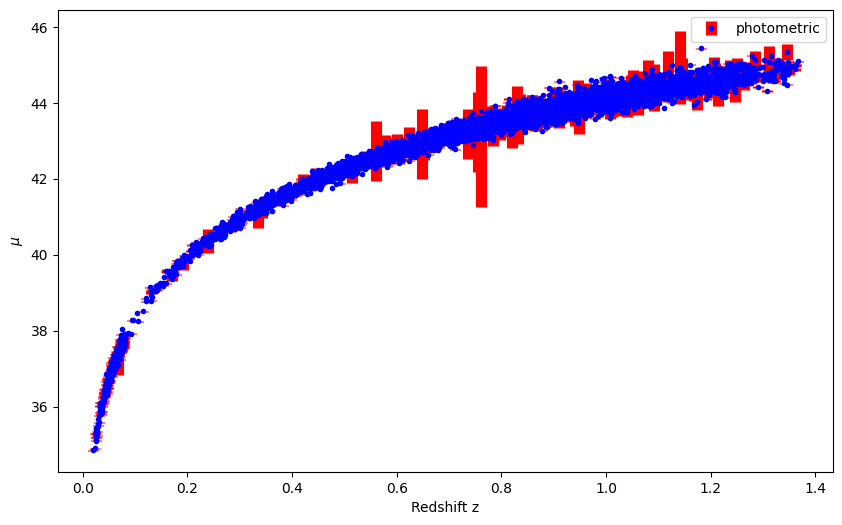

In [5]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(df_data['zCMB'].values, df_data['MU'].values, yerr=df_data['MUERR_SYS'].values, fmt='.', color='b', elinewidth=8, ecolor='red', label='photometric')
plt.ylabel("$\mu$")
plt.xlabel("Redshift z")
plt.legend()

In [6]:
df_data['errors'] = df_data['MUERR'].values+df_data['MUERR_SYS'].values
df_data.head()

,CID,IDSURVEY,zCMB,zHEL,MU,MUERR,MUERR_VPEC,MUERR_SYS,errors
0,SN:2521,50,0.01988,0.01988,34.84680,0.1320,0.0736,0.00796,0.13996
1,SN:57482,50,0.02321,0.02321,34.89863,0.1551,0.0631,0.00720,0.16230
2,SN:52921,50,0.02364,0.02364,35.28915,0.1243,0.0620,0.00771,0.13201
3,SN:21365,50,0.02470,0.02470,35.11988,0.1444,0.0594,0.00717,0.15157
4,SN:117311,50,0.02471,0.02471,35.19347,0.1232,0.0593,0.00702,0.13022


In [7]:
type(df_data)

pandas.core.frame.DataFrame

In [8]:
df_data = df_data[['zCMB', 'MU', 'errors']]

In [9]:
df_data.head(), len(df_data)

(      zCMB        MU   errors
 0  0.01988  34.84680  0.01592
 1  0.02321  34.89863  0.01440
 2  0.02364  35.28915  0.01542
 3  0.02470  35.11988  0.01434
 4  0.02471  35.19347  0.01404,
 5785)

In [10]:
randomize = np.random.permutation(len(df_data))
df_vals = df_data.values[randomize]

z = df_vals[:,0]
y = df_vals[:,1:]

In [11]:
scalerz = StandardScaler()
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

In [12]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [13]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

zmodel = np.linspace(0.01, 2.4, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

In [14]:
yy = y[:,0].reshape(-1,1)
zz = z
split = 0.8
ntrain = int(split * len(zz))
indx = [ntrain]
zz_train, zz_test = np.split(zz, indx)
yy_train, yy_test = np.split(yy, indx)
np.shape(zz_train), np.shape(yy_train), np.shape(zz_test), np.shape(yy_test)

((4628, 1), (4628, 1), (1157, 1), (1157, 1))

In [15]:
population_size = 4  # max of individuals per generation
max_generations = 10    # number of generations
gene_length = 8        # lenght of the gene, depends on how many hiperparameters are tested 2*hyp
k = 1                  # num. of finalist individuals

t = time.time()
datos = []

# Define the hyperparameters for the search
hyperparams = {'deep': [3, 4], 'num_units': [100, 200], 'batch_size': [8, 16, 32, 64]}

# generate a Nnogada instance
net_fit = Nnogada(hyp_to_find=hyperparams, X_train=zz_train, Y_train=yy_train, X_val=zz_test, Y_val=yy_test, neural_library='keras', regression=True)
# Set the possible values of hyperparameters and not use the default values from hyperparameters.py
net_fit.set_hyperparameters()

Using CPU


In [16]:
# best solution
best_population = net_fit.ga_with_elitism(population_size, max_generations, gene_length, k)

  0%|                                                                                                                             | 0/10 [00:00<?, ?it/s]2023-08-09 14:09:20.719574: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-08-09 14:09:20.719655: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: isidro-PC
2023-08-09 14:09:20.719676: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: isidro-PC
2023-08-09 14:09:20.719926: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.125.6
2023-08-09 14:09:20.719990: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 525.125.6
2023-08-09 14:09:20.720009: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version s


Best 5 solutions:
-----------------

   deep  num_units  batch_size      loss     score       time
0     4        200          32  0.025281  0.025281  23.670403
1     4        200          32  0.032538  0.032538  23.597835
2     4        200          32  0.033157  0.033157  23.607430
3     4        200           8  0.033687  0.033687  77.192532
4     4        200          32  0.034361  0.034361  24.007611


In [19]:
print(best_population)
print("Total elapsed time:", (time.time()-t)/60, "minutes")

[[1, 1, 0, 0, 1, 0, 0, 1]]
Total elapsed time: 149.29883574644725 minutes
